<a id='top'></a>

# Capology Player Web Scraping
##### Notebook to engineer scraped data

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 01/08/2021<br>
Notebook last updated: 07/08/2021

![title](../../img/logos/capology-logo.jpeg)

Click [here](#section5) to jump straight to the Exploratory Data Analysis section and skip the [Task Brief](#section2), [Data Scraping](#section3), and [Data Unification](#section4) sections. Or click [here](#section5) to jump straight to the Conclusion.

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook scrapes player statstics data from [Capology](https://www.capology.com/), using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames, and [Selenium](https://www.selenium.dev/) and [Beautifulsoup](https://pypi.org/project/beautifulsoup4/) for webscraping.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Player%20Salary%20Data%20Engineering.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
4.    [Data Engineering](#section4)<br>
5.    [Export Data](#section5)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing; and
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation.

All packages used for this notebook except for [`Beautifulsoup`](https://pypi.org/project/beautifulsoup4/) and [`Selenium`](https://www.selenium.dev/) can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
#import pandas_profiling as pp
import os
import re
import random
import glob
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os

# Working with JSON
import json
from pandas.io.json import json_normalize

# Web Scraping
from selenium import webdriver
from bs4 import BeautifulSoup
import requests
from bs4 import BeautifulSoup
import re

# Currency Converter
from currency_converter import CurrencyConverter

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# Progress Bar
from tqdm import tqdm

# Display in Jupyter
from IPython.display import Image, Video, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd')

print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))

Python: 3.7.6
NumPy: 1.20.3
pandas: 1.3.2


### Defined Variables and Lists

##### Date 

In [3]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

In [4]:
# Define variables and lists

## Define season
season = '2020'    # '2020' for the 20/21 season

# Create 'Full Season' and 'Short Season' strings

## Full season
full_season_string = str(int(season)) + '/' + str(int(season) + 1)

## Short season
short_season_string = str((str(int(season))[-2:]) + (str(int(season) + 1)[-2:]))

### Defined Filepaths

In [5]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_capology = os.path.join(base_dir, 'data', 'capology')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')

### Create Directory Structure

In [6]:
# Make the directory structure
for folder in ['archive']:
    path = os.path.join(data_dir_capology, 'engineered', folder)
    if not os.path.exists(path):
        os.mkdir(path)

### Notebook Settings

In [7]:
# Display all columns of displayed pandas DataFrames
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>

### <a id='#section2.1'>2.1. About this notebook</a>
This Jupyter notebook is part of a series of notebooks to scrape, parse, engineer, unify, and then model, culminating in a an Expected Transfer (xTransfer) player performance vs. valuation model. This model aims to determine the under- and over-performing players based on their on-the-pitch output against transfer fee and wages.

This particular notebook is one of several **data engineering** notebooks, that takes player salary data previously from the [Capology](https://www.capology.com/), and manipulates it to a clean form as Dataframes using [pandas](http://pandas.pydata.org/).

This notebook, along with the other notebooks in this project workflow are shown in the following diagram:

![roadmap](../../img/football_analytics_data_roadmap.png)

Links to these notebooks in the [`football_analytics`](https://github.com/eddwebster/football_analytics) GitHub repository can be found at the following:
*    [Webscraping](https://github.com/eddwebster/football_analytics/tree/master/notebooks/1_data_scraping)
     +    [FBref Player Stats Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/FBref%20Player%20Stats%20Web%20Scraping.ipynb)
     +    [TransferMarket Player Bio and Status Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Bio%20and%20Status%20Web%20Scraping.ipynb)
     +    [TransferMarkt Player Recorded Transfer Fees Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Webscraping.ipynb)
     +    [Capology Player Salary Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/Capology%20Player%20Salary%20Web%20Scraping.ipynb)
     +    [FBref Team Stats Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/FBref%20Team%20Stats%20Web%20Scraping.ipynb)
*    [Data Parsing](https://github.com/eddwebster/football_analytics/tree/master/notebooks/2_data_parsing)
     +    [ELO Team Ratings Data Parsing](https://github.com/eddwebster/football_analytics/blob/master/notebooks/2_data_parsing/ELO%20Team%20Ratings%20Data%20Parsing.ipynb)
*    [Data Engineering](https://github.com/eddwebster/football_analytics/tree/master/notebooks/3_data_engineering)
     +    [FBref Player Stats Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/FBref%20Player%20Stats%20Data%20Engineering.ipynb)
     +    [TransferMarket Player Bio and Status Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Bio%20and%20Status%20Data%20Engineering.ipynb)
     +    [TransferMarkt Player Recorded Transfer Fees Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Data%20Engineering.ipynb)
     +    [Capology Player Salary Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Player%20Salary%20Data%20Engineering.ipynb)
     +    [FBref Team Stats Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/FBref%20Team%20Stats%20Data%20Engineering.ipynb)
     +    [ELO Team Ratings Data Parsing](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/ELO%20Team%20Ratings%20Data%20Parsing.ipynb)
     +    [TransferMarkt Team Recorded Transfer Fee Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Team%20Recorded%20Transfer%20Fee%20Data%20Engineering.ipynb) (aggregated from [TransferMarkt Player Recorded Transfer Fees notebook](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Data%20Engineering.ipynb))
     +    [Capology Team Salary Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Team%20Salary%20Data%20Engineering.ipynb) (aggregated from [Capology Player Salary notebook](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Player%20Salary%20Data%20Engineering.ipynb))
*    [Data Unification](https://github.com/eddwebster/football_analytics/tree/master/notebooks/4_data_unification)
     +    [Golden ID for Player Level Datasets](https://github.com/eddwebster/football_analytics/blob/master/notebooks/4_data_unification/Golden%20ID%20for%20Player%20Level%20Datasets.ipynb)
     +    [Golden ID for Team Level Datasets](https://github.com/eddwebster/football_analytics/blob/master/notebooks/4_data_unification/Golden%20ID%20for%20Team%20Level%20Datasets.ipynb)
*    [Production Datasets](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets)
     +    [Player Performance/Market Value Dataset](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets/Player%20Performance/Market%20Value%20Dataset.ipynb)
     +    [Team Performance/Market Value Dataset](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets/Team%20Performance/Market%20Value%20Dataset.ipynb)
*    [Expected Transfer (xTransfer) Modeling](https://github.com/eddwebster/football_analytics/tree/master/notebooks/6_data_analysis_and_projects/expected_transfer_modeling)
     +    [Expected Transfer (xTransfer) Modeling](https://github.com/eddwebster/football_analytics/tree/master/notebooks/6_data_analysis_and_projects/expected_transfer_modeling/Expected%20Transfer%20%20Modeling.ipynb)

**Notebook Conventions**:<br>
*    Variables that refer a `DataFrame` object are prefixed with `df_`.
*    Variables that refer to a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

### <a id='#section3.1'>3.1. Introduction</a>
...

### <a id='#section3.2'>3.2. Data Dictionary</a>

The raw dataset has one hundred and eighty eight features (columns) with the following definitions and data types:

| Variable     | Data Type    | Description    |
|------|-----|-----|
| `squad`    | object    | ...    |
| `players_used`    | float64    | ...    |

<br>

The features will be cleaned, converted and also additional features will be created in the [Data Engineering](#section4) section (Section 4).

### <a id='#section3.3'>3.3. Read in CSV as pandas DataFrame</a>
The following cell reads the the `CSV` file as a pandas `DataFrame`.

In [8]:
# Read data directory
print(glob.glob(os.path.join(data_dir_capology, 'raw/*.csv')))

['../../data/capology/raw/capology_all_latest.csv']


In [9]:
# Import data as a pandas DataFrame, df_capology_raw
df_capology_raw = pd.read_csv(data_dir_capology + '/raw/capology_all_latest.csv')

### <a id='#section3.4'>3.4. Initial Data Handling</a>

#### <a id='#section3.4.1'>3.4.1. Summary Report</a>
Initial step of the data handling and Exploratory Data Analysis (EDA) is to create a quick summary report of the dataset using [pandas Profiling Report](https://github.com/pandas-profiling/pandas-profiling).

In [10]:
# Summary of the data using pandas Profiling Report
#pp.ProfileReport(df_capology_raw)

#### <a id='#section3.3.2'>3.3.2. Further Inspection</a>
The following commands go into more bespoke summary of the dataset. Some of the commands include content covered in the [pandas Profiling](https://github.com/pandas-profiling/pandas-profiling) summary above, but using the standard [pandas](https://pandas.pydata.org/) functions and methods that most peoplem will be more familiar with.

First check the quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [11]:
# Display the first five rows of the raw DataFrame, df_capology_raw
df_capology_raw.head()

,Unnamed: 0,Unnamed: 0.1,Player,Weekly GrossBase Salary(IN EUR),Annual GrossBase Salary(IN EUR),"Adj. GrossBase Salary(2021, IN EUR)",Pos.,Age,Country,Team,League,Season,Status,Expiration,Length,EstimatedGross Total(IN EUR),Unnamed: 2,Weekly GrossBase Salary(IN GBP),Annual GrossBase Salary(IN GBP),"Adj. GrossBase Salary(2021, IN GBP)",EstimatedGross Total(IN GBP),Weekly GrossBase Salary(IN USD),Annual GrossBase Salary(IN USD),"Adj. GrossBase Salary(2021, IN USD)",RosterStatus,EstimatedGross Total(IN USD)
0,0,0.0,Gonzalo Higuaín,"€ 338,327","€ 17,593,000","€ 17,568,773",F,30,Argentina,Ac Milan,Serie A,2018-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,Gianluigi Donnarumma,"€ 213,673","€ 11,111,000","€ 11,095,699",K,19,Italy,Ac Milan,Serie A,2018-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.0,Lucas Biglia,"€ 124,635","€ 6,481,000","€ 6,472,075",M,32,Argentina,Ac Milan,Serie A,2018-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3.0,Alessio Romagnoli,"€ 124,635","€ 6,481,000","€ 6,472,075",D,23,Italy,Ac Milan,Serie A,2018-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4.0,Tiemoué Bakayoko,"€ 124,635","€ 6,481,000","€ 6,472,075",M,23,France,Ac Milan,Serie A,2018-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Display the last five rows of the raw DataFrame, df_capology_raw
df_capology_raw.tail()

,Unnamed: 0,Unnamed: 0.1,Player,Weekly GrossBase Salary(IN EUR),Annual GrossBase Salary(IN EUR),"Adj. GrossBase Salary(2021, IN EUR)",Pos.,Age,Country,Team,League,Season,Status,Expiration,Length,EstimatedGross Total(IN EUR),Unnamed: 2,Weekly GrossBase Salary(IN GBP),Annual GrossBase Salary(IN GBP),"Adj. GrossBase Salary(2021, IN GBP)",EstimatedGross Total(IN GBP),Weekly GrossBase Salary(IN USD),Annual GrossBase Salary(IN USD),"Adj. GrossBase Salary(2021, IN USD)",RosterStatus,EstimatedGross Total(IN USD)
25154,35,35.0,Pedro Martínez,€ 0,€ 0,€ 0,M,21,Spain,Villarreal,La Liga,2017-2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25155,36,36.0,Chuca,€ 0,€ 0,€ 0,M,20,Spain,Villarreal,La Liga,2017-2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25156,37,37.0,Cédric Bakambu,€ 0,€ 0,€ 0,F,26,Democratic Republic of Congo,Villarreal,La Liga,2017-2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25157,38,38.0,Bruno Soriano,€ 0,€ 0,€ 0,M,33,Spain,Villarreal,La Liga,2017-2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25158,39,39.0,Sergio Lozano,€ 0,€ 0,€ 0,M,18,Spain,Villarreal,La Liga,2017-2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Print the shape of the raw DataFrame, df_capology_raw
print(df_capology_raw.shape)

(25159, 26)


In [14]:
# Print the column names of the raw DataFrame, df_capology_raw
print(df_capology_raw.columns)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Player',
       'Weekly GrossBase Salary(IN EUR)', 'Annual GrossBase Salary(IN EUR)',
       'Adj. GrossBase Salary(2021, IN EUR)', 'Pos.', 'Age', 'Country', 'Team',
       'League', 'Season', 'Status', 'Expiration', 'Length',
       'EstimatedGross Total(IN EUR)', 'Unnamed: 2',
       'Weekly GrossBase Salary(IN GBP)', 'Annual GrossBase Salary(IN GBP)',
       'Adj. GrossBase Salary(2021, IN GBP)', 'EstimatedGross Total(IN GBP)',
       'Weekly GrossBase Salary(IN USD)', 'Annual GrossBase Salary(IN USD)',
       'Adj. GrossBase Salary(2021, IN USD)', 'RosterStatus',
       'EstimatedGross Total(IN USD)'],
      dtype='object')


The dataset has ten features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [15]:
# Data types of the features of the raw DataFrame, df_capology_raw
df_capology_raw.dtypes

Unnamed: 0                               int64
Unnamed: 0.1                           float64
Player                                  object
Weekly GrossBase Salary(IN EUR)         object
Annual GrossBase Salary(IN EUR)         object
Adj. GrossBase Salary(2021, IN EUR)     object
Pos.                                    object
Age                                     object
Country                                 object
Team                                    object
League                                  object
Season                                  object
Status                                 float64
Expiration                              object
Length                                  object
EstimatedGross Total(IN EUR)            object
Unnamed: 2                             float64
Weekly GrossBase Salary(IN GBP)         object
Annual GrossBase Salary(IN GBP)         object
Adj. GrossBase Salary(2021, IN GBP)     object
EstimatedGross Total(IN GBP)            object
Weekly GrossB

In [16]:
# Info for the raw DataFrame, df_capology_raw
df_capology_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25159 entries, 0 to 25158
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Unnamed: 0                           25159 non-null  int64  
 1   Unnamed: 0.1                         18560 non-null  float64
 2   Player                               24661 non-null  object 
 3   Weekly GrossBase Salary(IN EUR)      16516 non-null  object 
 4   Annual GrossBase Salary(IN EUR)      16516 non-null  object 
 5   Adj. GrossBase Salary(2021, IN EUR)  15360 non-null  object 
 6   Pos.                                 25159 non-null  object 
 7   Age                                  25159 non-null  object 
 8   Country                              22691 non-null  object 
 9   Team                                 25159 non-null  object 
 10  League                               25159 non-null  object 
 11  Season                      

In [17]:
# Description of the raw DataFrame, df_capology_raw, showing some summary statistics for each numerical column in the DataFrame
df_capology_raw.describe()

,Unnamed: 0,Unnamed: 0.1,Status,Unnamed: 2
count,25159.000000,18560.000000,0.0,0.0
mean,17.252832,17.614709,NaN,NaN
std,11.422048,11.794968,NaN,NaN
min,0.000000,0.000000,NaN,NaN
25%,8.000000,8.000000,NaN,NaN
50%,16.000000,17.000000,NaN,NaN
75%,25.000000,25.000000,NaN,NaN
max,84.000000,84.000000,NaN,NaN


<AxesSubplot:>

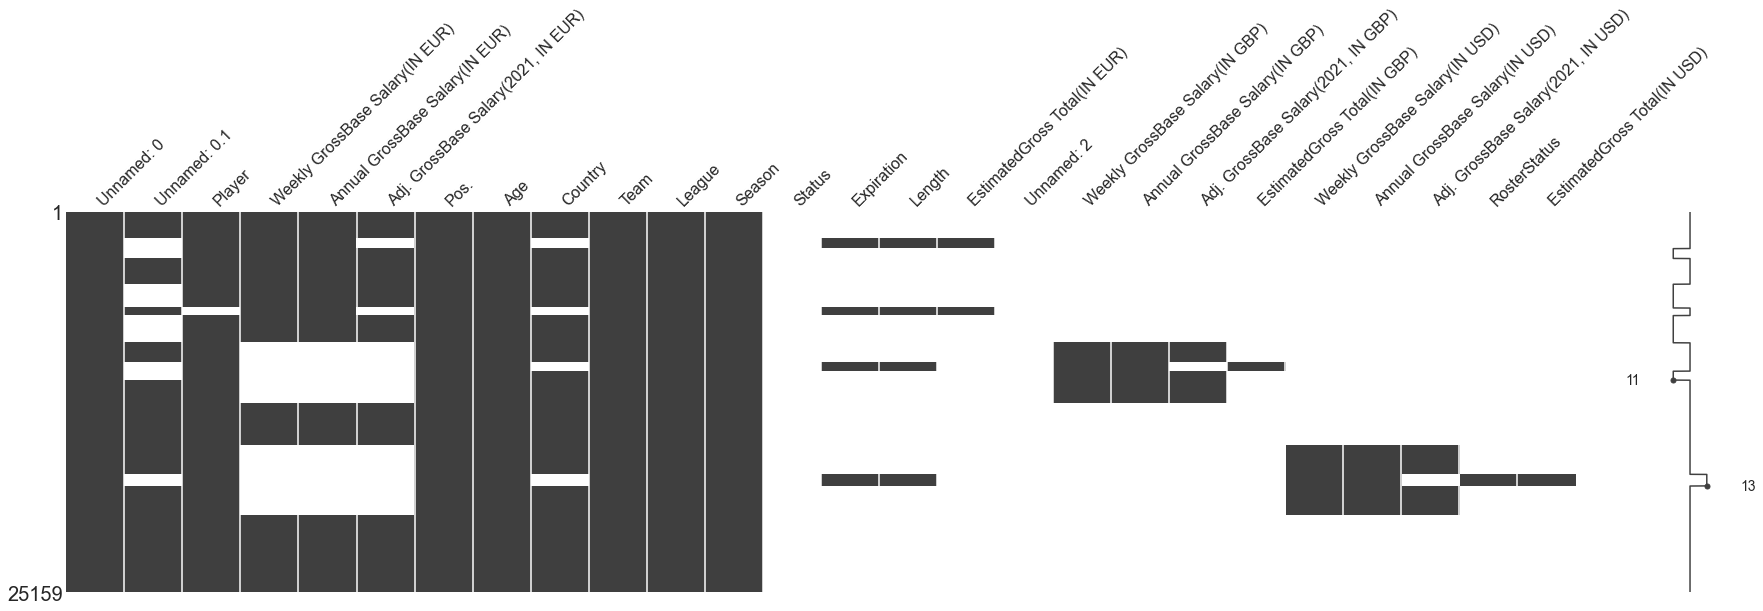

In [18]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_capology_raw
msno.matrix(df_capology_raw, figsize = (30, 7))

In [19]:
# Counts of missing values
null_value_stats = df_capology_raw.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Unnamed: 0.1                            6599
Player                                   498
Weekly GrossBase Salary(IN EUR)         8643
Annual GrossBase Salary(IN EUR)         8643
Adj. GrossBase Salary(2021, IN EUR)     9799
Country                                 2468
Status                                 25159
Expiration                             22691
Length                                 22691
EstimatedGross Total(IN EUR)           24003
Unnamed: 2                             25159
Weekly GrossBase Salary(IN GBP)        21163
Annual GrossBase Salary(IN GBP)        21163
Adj. GrossBase Salary(2021, IN GBP)    21709
EstimatedGross Total(IN GBP)           24613
Weekly GrossBase Salary(IN USD)        20512
Annual GrossBase Salary(IN USD)        20512
Adj. GrossBase Salary(2021, IN USD)    21278
RosterStatus                           24393
EstimatedGross Total(IN USD)           24393
dtype: int64

The visualisation shows us very quickly that there are missing values in a number of the columns, such as the financial columns such as Estimated Gross Total. This is because depending on the country, the financial values are only scraped in one country. This need to be coalesced.

This concludes the data handling section, the next thing to do is engineer the raw dataset to be ready for further analysis.

---

## <a id='#section4'>4. Data Engineering</a>
Before any Data Analysis, we first need to clean and wrangle the datasets to a form that meet our needs.

Still to add:
- Original value columns

### <a id='#section4.1'>4.1. Assign Raw DataFrame to Engineered DataFrame
From this point, all changes made to the dataset applied to the new engineered DataFrame, `df_capology`.

In [20]:
# Assign Raw DataFrame to Engineered DataFrame
df_capology = df_capology_raw.copy()

# Display DataFrame
df_capology.head() 

,Unnamed: 0,Unnamed: 0.1,Player,Weekly GrossBase Salary(IN EUR),Annual GrossBase Salary(IN EUR),"Adj. GrossBase Salary(2021, IN EUR)",Pos.,Age,Country,Team,League,Season,Status,Expiration,Length,EstimatedGross Total(IN EUR),Unnamed: 2,Weekly GrossBase Salary(IN GBP),Annual GrossBase Salary(IN GBP),"Adj. GrossBase Salary(2021, IN GBP)",EstimatedGross Total(IN GBP),Weekly GrossBase Salary(IN USD),Annual GrossBase Salary(IN USD),"Adj. GrossBase Salary(2021, IN USD)",RosterStatus,EstimatedGross Total(IN USD)
0,0,0.0,Gonzalo Higuaín,"€ 338,327","€ 17,593,000","€ 17,568,773",F,30,Argentina,Ac Milan,Serie A,2018-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,Gianluigi Donnarumma,"€ 213,673","€ 11,111,000","€ 11,095,699",K,19,Italy,Ac Milan,Serie A,2018-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.0,Lucas Biglia,"€ 124,635","€ 6,481,000","€ 6,472,075",M,32,Argentina,Ac Milan,Serie A,2018-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3.0,Alessio Romagnoli,"€ 124,635","€ 6,481,000","€ 6,472,075",D,23,Italy,Ac Milan,Serie A,2018-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4.0,Tiemoué Bakayoko,"€ 124,635","€ 6,481,000","€ 6,472,075",M,23,France,Ac Milan,Serie A,2018-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <a id='#section4.2'>4.2. Clean Data

In [21]:
df_capology['Weekly GrossBase Salary(IN EUR)'] =  (df_capology['Weekly GrossBase Salary(IN EUR)']
                                                          .replace('None', np.nan)
                                                          .astype(str)
                                                          .str.replace('£','')
                                                          .str.replace('€','')
                                                          .str.replace('$','')
                                                          .str.replace(',','')
                                                          .str.extract('(\d+)', expand=False)
                                                     ).astype(float)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [22]:
df_capology['Weekly GrossBase Salary(IN EUR)'] =  (df_capology['Weekly GrossBase Salary(IN EUR)']
                                                          .replace('None', np.nan)
                                                          .astype(str)
                                                          .str.replace('£','')
                                                          .str.replace('€','')
                                                          .str.replace('$','')
                                                          .str.replace(',','')
                                                          .str.extract('(\d+)', expand=False)
                                                     ).astype(float)

df_capology['Annual GrossBase Salary(IN EUR)'] = (df_capology['Annual GrossBase Salary(IN EUR)']
                                                          .replace('None', np.nan)
                                                          .astype(str)
                                                          .str.replace('£','')
                                                          .str.replace('€','')
                                                          .str.replace('$','')
                                                          .str.replace(',','')
                                                          .str.extract('(\d+)', expand=False)
                                                     ).astype(float)

df_capology['EstimatedGross Total(IN EUR)'] = (df_capology['EstimatedGross Total(IN EUR)']
                                                      .replace('None', np.nan)
                                                      .astype(str)
                                                      .str.replace('£','')
                                                      .str.replace('€','')
                                                      .str.replace('$','')
                                                      .str.replace(',','')
                                                      .str.extract('(\d+)', expand=False)
                                                 ).astype(float)

df_capology['Adj. GrossBase Salary(2021, IN EUR)'] = (df_capology['Adj. GrossBase Salary(2021, IN EUR)']
                                                             .replace('None', np.nan)
                                                             .astype(str)
                                                             .str.replace('£','')
                                                             .str.replace('€','')
                                                             .str.replace('$','')
                                                             .str.replace(',','')
                                                             .str.extract('(\d+)', expand=False)
                                                        ).astype(float)

df_capology['Weekly GrossBase Salary(IN USD)'] = (df_capology['Weekly GrossBase Salary(IN USD)']
                                                         .replace('None', np.nan)
                                                         .astype(str)
                                                         .str.replace('£','')
                                                         .str.replace('€','')
                                                         .str.replace('$','')
                                                         .str.replace(',','')
                                                         .str.extract('(\d+)', expand=False)
                                                    ).astype(float)

df_capology['Annual GrossBase Salary(IN USD)'] = (df_capology['Annual GrossBase Salary(IN USD)']
                                                          .replace('None', np.nan)
                                                          .astype(str)
                                                          .str.replace('£','')
                                                          .str.replace('€','')
                                                          .str.replace('$','')
                                                          .str.replace(',','')
                                                          .str.extract('(\d+)', expand=False)
                                                     ).astype(float)

df_capology['EstimatedGross Total(IN USD)'] = (df_capology['EstimatedGross Total(IN USD)']
                                                      .replace('None', np.nan)
                                                      .astype(str)
                                                      .str.replace('£','')
                                                      .str.replace('€','')
                                                      .str.replace('$','')
                                                      .str.replace(',','')
                                                      .str.extract('(\d+)', expand=False)
                                                 ).astype(float)

df_capology['Adj. GrossBase Salary(2021, IN USD)'] = (df_capology['Adj. GrossBase Salary(2021, IN USD)']
                                                              .replace('None', np.nan)
                                                              .astype(str)
                                                              .str.replace('£','')
                                                              .str.replace('€','')
                                                              .str.replace('$','')
                                                              .str.replace(',','')
                                                              .str.extract('(\d+)', expand=False)
                                                         ).astype(float)

df_capology['Weekly GrossBase Salary(IN GBP)'] = (df_capology['Weekly GrossBase Salary(IN GBP)']
                                                          .replace('None', np.nan)
                                                          .astype(str)
                                                          .str.replace('£','')
                                                          .str.replace('€','')
                                                          .str.replace('$','')
                                                          .str.replace(',','')
                                                          .str.extract('(\d+)', expand=False)
                                                     ).astype(float)

df_capology['Annual GrossBase Salary(IN GBP)'] = (df_capology['Annual GrossBase Salary(IN GBP)']
                                                          .replace('None', np.nan)
                                                          .astype(str)
                                                          .str.replace('£','')
                                                          .str.replace('€','')
                                                          .str.replace('$','')
                                                          .str.replace(',','')
                                                          .str.extract('(\d+)', expand=False)
                                                     ).astype(float)

df_capology['EstimatedGross Total(IN GBP)'] = (df_capology['EstimatedGross Total(IN GBP)']
                                                      .replace('None', np.nan)
                                                      .astype(str)
                                                      .str.replace('£','')
                                                      .str.replace('€','')
                                                      .str.replace('$','')
                                                      .str.replace(',','')
                                                      .str.extract('(\d+)', expand=False)
                                                 ).astype(float)

df_capology['Adj. GrossBase Salary(2021, IN GBP)'] = (df_capology['Adj. GrossBase Salary(2021, IN GBP)']
                                                              .replace('None', np.nan)
                                                              .astype(str)
                                                              .str.replace('£','')
                                                              .str.replace('€','')
                                                              .str.replace('$','')
                                                              .str.replace(',','')
                                                              .str.extract('(\d+)', expand=False)
                                                         ).astype(float)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: The default value of regex will change from True to False in a future ver

In [23]:
#
df_capology['Currency'] = np.where(df_capology['Annual GrossBase Salary(IN EUR)'].notnull(), 'EUR',
                                      np.where(df_capology['Annual GrossBase Salary(IN GBP)'].notnull(), 'GBP',
                                               np.where(df_capology['Annual GrossBase Salary(IN EUR)'].notnull(), 'USD', 'n/a')
                                              )
                                     )

In [24]:
# Get EUR to GBP exchange rate

## Get latest currency rates
c = CurrencyConverter()

##  Get conversion rate from EUR to GBP
rate_eur_gbp = (c.convert(1, 'EUR', 'GBP'))
rate_eur_gbp

##  Get conversion rate from USD to GBP
rate_usd_gbp = (c.convert(1, 'USD', 'GBP'))
rate_usd_gbp

##  
rate_gbp_gbp = 1
rate_gbp_gbp

1

In [25]:
df_capology['Exchange Rate'] = np.where(df_capology['Currency'] == 'EUR', rate_eur_gbp,
                                           np.where(df_capology['Currency'] == 'USD', rate_usd_gbp,
                                                     np.where(df_capology['Currency'] == 'GBP', 1, np.nan)
                                                   )
                                          )

df_capology['Exchange Rate'] = df_capology['Exchange Rate'].replace('None', np.nan).astype(float)

In [26]:
#

## Coalesce the four salary columns

###
df_capology['Estimated Gross Total Original'] = (df_capology['EstimatedGross Total(IN GBP)']
                                                        .combine_first(df_capology['EstimatedGross Total(IN GBP)'])
                                                        .combine_first(df_capology['EstimatedGross Total(IN USD)'])
                                                        .replace('None', np.nan)
                                                        .astype(float)
                                                   )

df_capology['Estimated Gross Total GBP'] = (df_capology['Estimated Gross Total Original'] * df_capology['Exchange Rate'])

df_capology['Estimated Gross Total GBP'] = (df_capology['Estimated Gross Total GBP']
                                                      .fillna(-1)
                                                      .astype(int)
                                                      .astype(str)
                                                      .replace('-1', np.nan)
                                                 )

###
df_capology['Weekly Gross Base Salary Original'] = (df_capology['Weekly GrossBase Salary(IN GBP)']
                                                           .combine_first(df_capology['Weekly GrossBase Salary(IN EUR)'])
                                                           .combine_first(df_capology['Weekly GrossBase Salary(IN USD)'])
                                                           .replace('None', np.nan)
                                                           .astype(float)
                                                      )

df_capology['Weekly Gross Base Salary GBP'] = df_capology['Weekly Gross Base Salary Original'] * df_capology['Exchange Rate']

df_capology['Weekly Gross Base Salary GBP'] = (df_capology['Weekly Gross Base Salary GBP']
                                                      .fillna(-1)
                                                      .astype(int)
                                                      .astype(str)
                                                      .replace('-1', np.nan)
                                                 )

###
df_capology['Annual Gross Base Salary Original'] = (df_capology['Annual GrossBase Salary(IN GBP)']
                                                           .combine_first(df_capology['Annual GrossBase Salary(IN EUR)'])
                                                           .combine_first(df_capology['Annual GrossBase Salary(IN USD)'])
                                                           .replace('None', np.nan)
                                                           .astype(float)
                                                      )

df_capology['Annual Gross Base Salary GBP'] = df_capology['Annual Gross Base Salary Original'] * df_capology['Exchange Rate']

df_capology['Annual Gross Base Salary GBP'] = (df_capology['Annual Gross Base Salary GBP']
                                                      .fillna(-1)
                                                      .astype(int)
                                                      .astype(str)
                                                      .replace('-1', np.nan)
                                                 )

###
df_capology['Adj. Gross Base Salary for Current Season Original'] = (df_capology['Adj. GrossBase Salary(2021, IN GBP)']
                                                                            .combine_first(df_capology['Adj. GrossBase Salary(2021, IN EUR)'])
                                                                            .combine_first(df_capology['Adj. GrossBase Salary(2021, IN USD)'])
                                                                            .replace('None', np.nan)
                                                                            .astype(float)
                                                                       )

df_capology['Adj. Gross Base Salary for Current Season GBP'] = df_capology['Adj. Gross Base Salary for Current Season Original'] * df_capology['Exchange Rate']

df_capology['Adj. Gross Base Salary for Current Season GBP'] = (df_capology['Adj. Gross Base Salary for Current Season GBP']
                                                                        .fillna(-1)
                                                                        .astype(int)
                                                                        .astype(str)
                                                                        .replace('-1', np.nan)
                                                                   )


## Coalesce the two status columns

###
df_capology['Status'] = (df_capology['Status']
                                .combine_first(df_capology['RosterStatus'])
                                .combine_first(df_capology['EstimatedGross Total(IN USD)'])
                                .replace('None', np.nan)
                                .astype(str)
                           )



In [27]:
df_capology = df_capology[~df_capology['Pos.'].isin(['No data available in table'])]

In [28]:
df_capology['Pos.'].unique()

array(['F', 'K', 'M', 'D', 'CF', 'CB', 'RB', 'LW', 'CM', 'GK', 'DM', 'RW',
       'LB', 'AM', 'SS', 'LM', 'RM'], dtype=object)

In [29]:
## Map Positions

### 
dict_positions_grouped = {'K': 'Goalkeeper',
                          'D': 'Defender',
                          'M': 'Midfielder',
                          'F': 'Forward',
                          'GK': 'Goalkeeper',
                          'LB': 'Defender',
                          'RB': 'Defender',
                          'CB': 'Defender',
                          'DM': 'Midfielder',
                          'LM': 'Midfielder',
                          'CM': 'Midfielder',
                          'RM': 'Midfielder',
                          'AM': 'Midfielder',
                          'LW': 'Forward',
                          'RW': 'Forward',
                          'SS': 'Forward',
                          'CF': 'Forward'
                         }

### Map grouped positions to DataFrame
df_capology['Pos.'] = df_capology['Pos.'].map(dict_positions_grouped)

In [30]:
## Separate Goalkeeper and Outfielders
df_capology['Outfielder Goalkeeper'] = np.where(df_capology['Pos.'].isnull(), np.nan, (np.where(df_capology['Pos.'] == 'Goalkeeper', 'Goalkeeper', 'Outfielder')))


## Define columns
cols = ['Player',
        'Season',
        'League',
        'Team',
        'Pos.',
        'Outfielder Goalkeeper',
        'Age',
        'Country',   
        'Weekly Gross Base Salary GBP',
        'Annual Gross Base Salary GBP',
        'Adj. Gross Base Salary for Current Season GBP',
        'Estimated Gross Total GBP',
        'Status',
        'Expiration',
        'Length'
       ]

## Select columns of interest
df_capology_select = df_capology[cols]

## Sort by 'mins_total' decending
df_capology_select = df_capology_select.sort_values(['League', 'Season', 'Team', 'Player'], ascending=[True, True, True, True])

## Drop index
df_capology_select = df_capology_select.reset_index(drop=True)

## Rename columns
df_capology_select = (df_capology_select
                             .rename(columns={'Player': 'player',
                                              'Season': 'season',
                                              'League': 'league',
                                              'Team': 'team',
                                              'Pos.': 'position',
                                              'Outfielder Goalkeeper': 'outfielder_goalkeeper',
                                              'Age': 'age',
                                              'Country': 'country',
                                              'Weekly Gross Base Salary GBP': 'weekly_gross_base_salary_gbp',
                                              'Annual Gross Base Salary GBP': 'annual_gross_base_salary_gbp',
                                              'Adj. Gross Base Salary for Current Season GBP': 'adj_current_gross_base_salary_gbp',
                                              'Estimated Gross Total GBP': 'estimated_gross_total_gbp',
                                              'Status': 'current_contract_status',
                                              'Expiration': 'current_contract_expiration',
                                              'Length': 'current_contract_length',
                                             }
                                    )
                        )

## 
df_capology_select.head(10)

,player,season,league,team,position,outfielder_goalkeeper,age,country,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length
0,Aaron Leya Iseka,2015-2016,Belgian First Division A,Anderlecht,Forward,Outfielder,17,Belgium,3757,195415,208123,NaN,nan,NaN,NaN
1,Alexander Büttner,2015-2016,Belgian First Division A,Anderlecht,Defender,Outfielder,26,Netherlands,18928,984279,1048291,NaN,nan,NaN,NaN
2,Andy Kawaya,2015-2016,Belgian First Division A,Anderlecht,Forward,Outfielder,18,Belgium,0,0,0,NaN,nan,NaN,NaN
3,Andy Nájar,2015-2016,Belgian First Division A,Anderlecht,Defender,Outfielder,22,Honduras,0,0,0,NaN,nan,NaN,NaN
4,Anthony Vanden Borre,2015-2016,Belgian First Division A,Anderlecht,Defender,Outfielder,27,Belgium,8676,451165,480506,NaN,nan,NaN,NaN
5,Bram Nuytinck,2015-2016,Belgian First Division A,Anderlecht,Defender,Outfielder,25,Netherlands,8676,451165,480506,NaN,nan,NaN,NaN
6,Davy Roef,2015-2016,Belgian First Division A,Anderlecht,Goalkeeper,Goalkeeper,21,Belgium,2892,150388,160169,NaN,nan,NaN,NaN
7,Dennis Praet,2015-2016,Belgian First Division A,Anderlecht,Midfielder,Outfielder,21,Belgium,13888,722225,769194,NaN,nan,NaN,NaN
8,Dodi Lukebakio,2015-2016,Belgian First Division A,Anderlecht,Forward,Outfielder,17,Belgium,1159,60335,64259,NaN,nan,NaN,NaN
9,Fabrice N'Sakala,2015-2016,Belgian First Division A,Anderlecht,Defender,Outfielder,24,Democratic Republic of the Congo,7238,376421,400901,NaN,nan,NaN,NaN


In [31]:
# Still to engineer
# - 'current_contract_status', 'current_contract_expiration', and 'current_contract_length' are blank unless it's a 2021 
#   row. The 2021 data can be joined back onto the previous years. May however need to scrape more of the data to
#   get contract information of players no longer in same leage (i.e. relegation, move abroad)

In [32]:
df_capology.loc[df_capology['Player'] == 'Albian Ajeti']

,Unnamed: 0,Unnamed: 0.1,Player,Weekly GrossBase Salary(IN EUR),Annual GrossBase Salary(IN EUR),"Adj. GrossBase Salary(2021, IN EUR)",Pos.,Age,Country,Team,League,Season,Status,Expiration,Length,EstimatedGross Total(IN EUR),Unnamed: 2,Weekly GrossBase Salary(IN GBP),Annual GrossBase Salary(IN GBP),"Adj. GrossBase Salary(2021, IN GBP)",EstimatedGross Total(IN GBP),Weekly GrossBase Salary(IN USD),Annual GrossBase Salary(IN USD),"Adj. GrossBase Salary(2021, IN USD)",RosterStatus,EstimatedGross Total(IN USD),Currency,Exchange Rate,Estimated Gross Total Original,Estimated Gross Total GBP,Weekly Gross Base Salary Original,Weekly Gross Base Salary GBP,Annual Gross Base Salary Original,Annual Gross Base Salary GBP,Adj. Gross Base Salary for Current Season Original,Adj. Gross Base Salary for Current Season GBP,Outfielder Goalkeeper
9953,15,15.0,Albian Ajeti,NaN,NaN,NaN,Forward,22,Switzerland,West Ham,Premier League,2019-2020,nan,NaN,NaN,NaN,NaN,50000.0,2600000.0,2600000.0,NaN,NaN,NaN,NaN,NaN,NaN,GBP,1.00000,NaN,NaN,50000.0,50000,2600000.0,2600000,2600000.0,2600000,Outfielder
21335,35,35.0,Albian Ajeti,0.0,0.0,0.0,Forward,19,Switzerland,Augsburg,Bundesliga,2016-2017,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EUR,0.90053,NaN,NaN,0.0,0,0.0,0,0.0,0,Outfielder


In [33]:
df_capology_select.loc[df_capology_select['player'] == 'Albian Ajeti']

,player,season,league,team,position,outfielder_goalkeeper,age,country,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length
3877,Albian Ajeti,2016-2017,Bundesliga,Augsburg,Forward,Outfielder,19,Switzerland,0,0,0,NaN,nan,NaN,NaN
19172,Albian Ajeti,2019-2020,Premier League,West Ham,Forward,Outfielder,22,Switzerland,50000,2600000,2600000,NaN,nan,NaN,NaN


### <a id='#section4.3'>4.3. Create Wide Dataset
1 row per player

In [34]:
# CODE HERE

### <a id='#section4.4'>4.4. Filter Players in 'Big 5' European Leagues
Create a separate DataFrame

In [35]:
df_capology_select['league'].unique()

array(['Belgian First Division A', 'Bundesliga', 'La Liga', 'Ligue 1',
       'Mls', 'Premier League', 'Serie A'], dtype=object)

In [36]:
# Filter plays in the Big 5 European Leagues

## Define list of countries
lst_big5_countries = ['Bundesliga', 'Ligue 1', 'Premier League', 'Serie A', 'La Liga', 'Mls']

## Filter list of Big 5 European League countries from DataFrame
df_capology_big5_mls_select = df_capology_select[df_capology_select['league'].isin(lst_big5_countries)]

In [37]:
df_capology_big5_mls_select.shape

(21281, 15)

---

<a id='section5'></a>

## <a id='#section5'>5. Export Datasets</a>

In [38]:
# Export DataFrames

## All teams
df_capology_select.to_csv(data_dir_capology + f'/engineered/archive/capology_all_1617_2122_last_updated_{today}.csv', index=None, header=True)
df_capology_select.to_csv(data_dir_capology + '/engineered/capology_all_latest.csv', index=None, header=True)

## Teams from the 'Big 5' European leagues and MLS
df_capology_big5_mls_select.to_csv(data_dir_capology + f'/engineered/archive/capology_big5_mls_1617_2122_last_updated_{today}.csv', index=None, header=True)
df_capology_big5_mls_select.to_csv(data_dir_capology + '/engineered/capology_big5_mls_latest.csv', index=None, header=True)

---

<a id='section6'></a>

## <a id='#section6'>6. Summary</a>
This notebook scrapes player statstics data from [Capology](https://www.capology.com/), using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

___

<a id='section7'></a>

## <a id='#section7'>7. Next Steps</a>
This engineered data is now ready to be analysed and joined to further engineered and joined to disparate datasets such as data from FBref and TransferMarkt.

___

<a id='section8'></a>

## <a id='#section8'>8. References</a>

#### Data and Web Scraping
*    
*    
*    

---

***Visit my website [eddwebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)